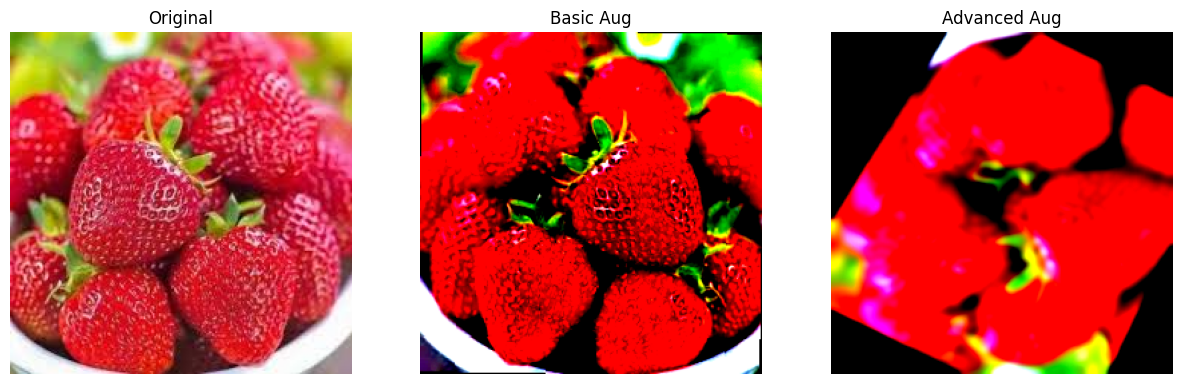

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image, ImageFilter, ImageEnhance
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise

class AdvancedImageAugmentation:
    def __init__(self, image_size=(256, 256)):
        self.image_size = image_size

    def get_basic_augmentation(self, train=True):
        """Базовые аугментации (для тренировки и валидации)"""
        if train:
            return transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.1),
                transforms.RandomRotation(degrees=15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            return transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def get_advanced_augmentation(self):
        """Продвинутые и интересные техники аугментации"""
        return transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.RandomApply([transforms.RandomAffine(
                degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10)], p=0.7),
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.1),
                transforms.RandomRotation(degrees=360)  # Полный поворот
            ]),
            transforms.RandomApply([transforms.ColorJitter(
                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2)], p=0.7),
            transforms.RandomApply([GaussianBlurCustom()], p=0.3),
            transforms.RandomApply([AddGaussianNoise()], p=0.3),
            transforms.RandomApply([ElasticTransform()], p=0.2),
            transforms.RandomApply([RandomErasingCustom()], p=0.2),
            transforms.RandomApply ([GridDistortion()], p=0.1),
            transforms.RandomApply ([Cutout()], p=0.1),
            transforms.RandomApply ([Solarize()], p=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# Кастомные классы для аугментаций
class GaussianBlurCustom:
    def __init__(self, radius_range=(1, 3)):
        self.radius_range = radius_range

    def __call__(self, img):
        radius = random.uniform(*self.radius_range)
        return img.filter(ImageFilter.GaussianBlur(radius))

class AddGaussianNoise:
    def __init__(self, var_limit=(0.01, 0.05)):
        self.var_limit = var_limit

    def __call__(self, img):
        img_np = np.array(img) / 255.0
        var = random.uniform(*self.var_limit)
        noisy_img = random_noise(img_np, mode='gaussian', var=var)
        noisy_img = (noisy_img * 255).astype(np.uint8)
        return Image.fromarray(noisy_img)

class ElasticTransform:
    def __init__(self, alpha_range=(30, 50), sigma_range=(5, 7)):
        self.alpha_range = alpha_range
        self.sigma_range = sigma_range

    def __call__(self, img):
        img_np = np.array(img)
        alpha = random.uniform(*self.alpha_range)
        sigma = random.uniform(*self.sigma_range)

        shape = img_np.shape[:2]
        dx = np.random.uniform(-1, 1, shape) * alpha
        dy = np.random.uniform(-1, 1, shape) * alpha

        from scipy.ndimage import gaussian_filter
        dx = gaussian_filter(dx, sigma)
        dy = gaussian_filter(dy, sigma)

        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

        distorted_img = np.zeros_like(img_np)
        for i in range(3):
            distorted_img[..., i] = map_coordinates(img_np[..., i], indices, order=1, mode='reflect').reshape(shape)

        return Image.fromarray(distorted_img)

class RandomErasingCustom:
    def __init__(self, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0):
        self.scale = scale
        self.ratio = ratio
        self.value = value

    def __call__(self, img):
        img_np = np.array(img)
        h, w, c = img_np.shape

        area = h * w
        target_area = random.uniform(*self.scale) * area
        aspect_ratio = random.uniform(*self.ratio)

        erasing_h = int(round(np.sqrt(target_area * aspect_ratio)))
        erasing_w = int(round(np.sqrt(target_area / aspect_ratio)))

        if erasing_h < h and erasing_w < w:
            x1 = random.randint(0, h - erasing_h)
            y1 = random.randint(0, w - erasing_w)
            img_np[x1:x1+erasing_h, y1:y1+erasing_w, :] = self.value

        return Image.fromarray(img_np)

class GridDistortion:
    def __init__(self, num_steps=5, distort_limit=0.3):
        self.num_steps = num_steps
        self.distort_limit = distort_limit

    def __call__(self, img):
        img_np = np.array(img)
        h, w = img_np.shape[:2]

        x_step = w // self.num_steps
        y_step = h // self.num_steps

        # Создаем сетку искажений
        horizontal_grid = np.zeros((self.num_steps + 1, h))
        vertical_grid = np.zeros((w, self.num_steps + 1))

        for i in range(self.num_steps + 1):
            horizontal_grid[i, :] = np.linspace(0, h-1, h)
            vertical_grid[:, i] = np.linspace(0, w-1, w)

            if 0 < i < self.num_steps:
                distortion = random.uniform(-self.distort_limit, self.distort_limit)
                horizontal_grid[i, :] += distortion * h
                vertical_grid[:, i] += distortion * w

        # Применяем искажение
        from scipy.interpolate import interp2d
        distorted_img = np.zeros_like(img_np)

        for c in range(3):
            interp = interp2d(np.arange(w), np.arange(h), img_np[..., c])
            channel = np.zeros((h, w))

            for y in range(h):
                for x in range(w):
                    x_idx = min(int(x / x_step), self.num_steps-1)
                    y_idx = min(int(y / y_step), self.num_steps-1)

                    new_x = vertical_grid[x, x_idx] + (vertical_grid[x, x_idx+1] - vertical_grid[x, x_idx]) * (x % x_step) / x_step
                    new_y = horizontal_grid[y_idx, y] + (horizontal_grid[y_idx+1, y] - horizontal_grid[y_idx, y]) * (y % y_step) / y_step

                    new_x = max(0, min(w-1, new_x))
                    new_y = max(0, min(h-1, new_y))

                    channel[y, x] = interp(new_x, new_y)

            distorted_img[..., c] = channel

        return Image.fromarray(distorted_img.astype(np.uint8))

class Cutout:
    def __init__(self, n_holes=1, length_ratio=0.2):
        self.n_holes = n_holes
        self.length_ratio = length_ratio

    def __call__(self, img):
        img_np = np.array(img)
        h, w = img_np.shape[:2]
        length = int(h * self.length_ratio)

        for _ in range(self.n_holes):
            y = random.randint(0, h - length)
            x = random.randint(0, w - length)

            # Заполняем случайным цветом или средним значением
            fill_value = random.randint(0, 255) if random.random() > 0.5 else np.mean(img_np)
            img_np[y:y+length, x:x+length] = fill_value

        return Image.fromarray(img_np)

class Solarize:
    def __init__(self, threshold=128):
        self.threshold = threshold

    def __call__(self, img):
        img_np = np.array(img)
        solarized = np.where(img_np < self.threshold, img_np, 255 - img_np)
        return Image.fromarray(solarized)

# Пример использования
if __name__ == "__main__":
    # Загрузка изображения
    image_path = "/content/клубничке.jpg"
    img = Image.open(image_path)

    aug = AdvancedImageAugmentation()

    # Базовые аугментации
    basic_aug = aug.get_basic_augmentation(train=True)
    basic_aug_img = basic_aug(img)

    # Продвинутые аугментации
    advanced_aug = aug.get_advanced_augmentation()
    advanced_aug_img = advanced_aug(img)

    # Визуализация
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Basic Aug")
    plt.imshow(basic_aug_img.permute(1, 2, 0))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Advanced Aug")
    plt.imshow(advanced_aug_img.permute(1, 2, 0))
    plt.axis('off')

    plt.show()

Error in Grid Distortion: `interp2d` has been removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
https://scipy.github.io/devdocs/tutorial/interpolate/interp_transition_guide.html

Error in Perspective: num must be an integer with 1 <= num <= 12, not 13


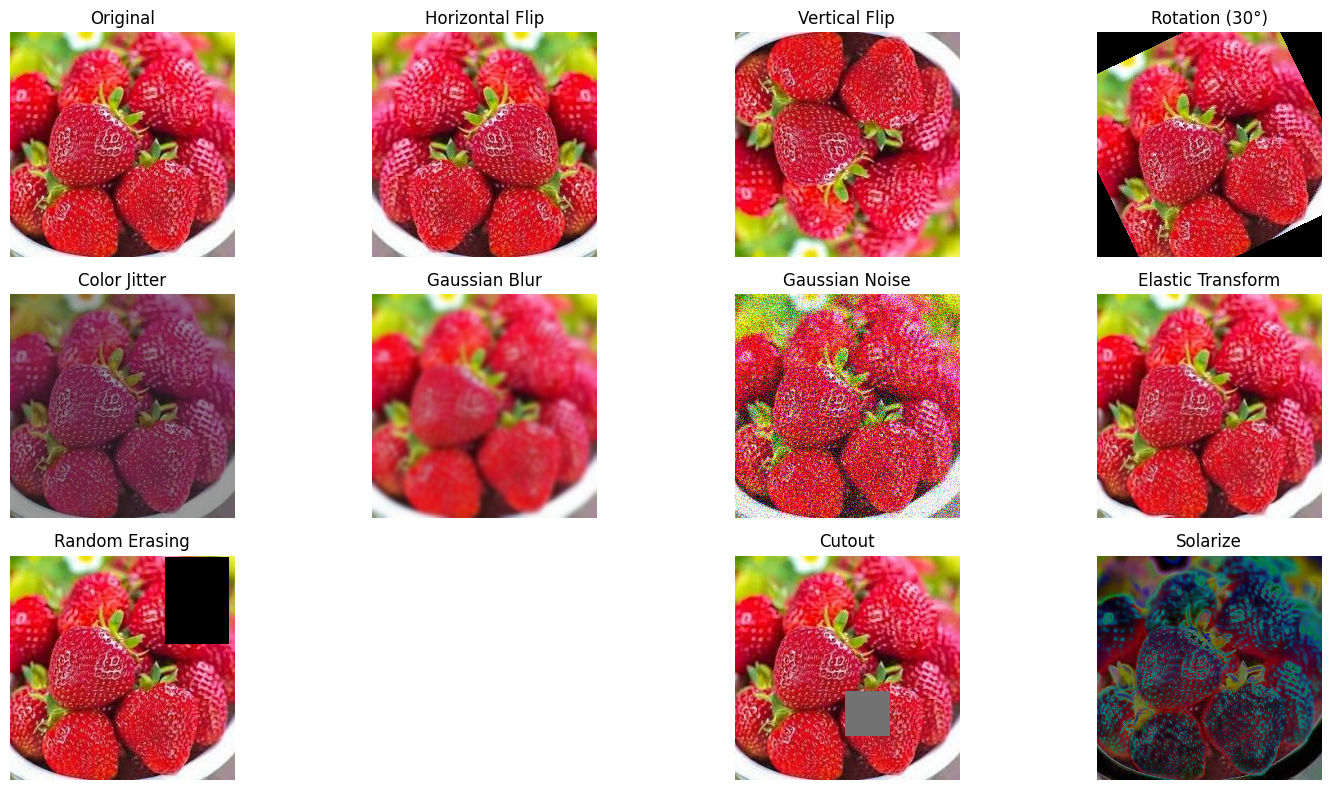

In [12]:
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image, ImageFilter, ImageEnhance
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import random_noise
from scipy.ndimage import map_coordinates, gaussian_filter
from scipy.interpolate import interp2d

# Кастомные классы для аугментаций
class GaussianBlurCustom:
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(self.radius))

class AddGaussianNoise:
    def __init__(self, var=0.03):
        self.var = var

    def __call__(self, img):
        img_np = np.array(img) / 255.0
        noisy_img = random_noise(img_np, mode='gaussian', var=self.var)
        noisy_img = (noisy_img * 255).astype(np.uint8)
        return Image.fromarray(noisy_img)

class ElasticTransform:
    def __init__(self, alpha=40, sigma=6):
        self.alpha = alpha
        self.sigma = sigma

    def __call__(self, img):
        img_np = np.array(img)
        shape = img_np.shape[:2]

        dx = np.random.uniform(-1, 1, shape) * self.alpha
        dy = np.random.uniform(-1, 1, shape) * self.alpha

        dx = gaussian_filter(dx, self.sigma)
        dy = gaussian_filter(dy, self.sigma)

        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
        indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

        distorted_img = np.zeros_like(img_np)
        for i in range(3):
            distorted_img[..., i] = map_coordinates(img_np[..., i], indices, order=1, mode='reflect').reshape(shape)

        return Image.fromarray(distorted_img)

class RandomErasingCustom:
    def __init__(self, scale=(0.1, 0.2), ratio=(0.5, 2), value=0):
        self.scale = scale
        self.ratio = ratio
        self.value = value

    def __call__(self, img):
        img_np = np.array(img)
        h, w, c = img_np.shape

        area = h * w
        target_area = random.uniform(*self.scale) * area
        aspect_ratio = random.uniform(*self.ratio)

        erasing_h = int(round(np.sqrt(target_area * aspect_ratio)))
        erasing_w = int(round(np.sqrt(target_area / aspect_ratio)))

        if erasing_h < h and erasing_w < w:
            x1 = random.randint(0, h - erasing_h)
            y1 = random.randint(0, w - erasing_w)
            img_np[x1:x1+erasing_h, y1:y1+erasing_w, :] = self.value

        return Image.fromarray(img_np)

class GridDistortion:
    def __init__(self, num_steps=5, distort_limit=0.3):
        self.num_steps = num_steps
        self.distort_limit = distort_limit

    def __call__(self, img):
        img_np = np.array(img)
        h, w = img_np.shape[:2]

        x_step = w // self.num_steps
        y_step = h // self.num_steps

        horizontal_grid = np.zeros((self.num_steps + 1, h))
        vertical_grid = np.zeros((w, self.num_steps + 1))

        for i in range(self.num_steps + 1):
            horizontal_grid[i, :] = np.linspace(0, h-1, h)
            vertical_grid[:, i] = np.linspace(0, w-1, w)

            if 0 < i < self.num_steps:
                distortion = random.uniform(-self.distort_limit, self.distort_limit)
                horizontal_grid[i, :] += distortion * h
                vertical_grid[:, i] += distortion * w

        distorted_img = np.zeros_like(img_np)

        for c in range(3):
            interp = interp2d(np.arange(w), np.arange(h), img_np[..., c])
            channel = np.zeros((h, w))

            for y in range(h):
                for x in range(w):
                    x_idx = min(int(x / x_step), self.num_steps-1)
                    y_idx = min(int(y / y_step), self.num_steps-1)

                    new_x = vertical_grid[x, x_idx] + (vertical_grid[x, x_idx+1] - vertical_grid[x, x_idx]) * (x % x_step) / x_step
                    new_y = horizontal_grid[y_idx, y] + (horizontal_grid[y_idx+1, y] - horizontal_grid[y_idx, y]) * (y % y_step) / y_step

                    new_x = max(0, min(w-1, new_x))
                    new_y = max(0, min(h-1, new_y))

                    channel[y, x] = interp(new_x, new_y)

            distorted_img[..., c] = channel

        return Image.fromarray(distorted_img.astype(np.uint8))

class Cutout:
    def __init__(self, n_holes=1, length_ratio=0.2):
        self.n_holes = n_holes
        self.length_ratio = length_ratio

    def __call__(self, img):
        img_np = np.array(img)
        h, w = img_np.shape[:2]
        length = int(h * self.length_ratio)

        for _ in range(self.n_holes):
            y = random.randint(0, h - length)
            x = random.randint(0, w - length)

            fill_value = random.randint(0, 255) if random.random() > 0.5 else np.mean(img_np)
            img_np[y:y+length, x:x+length] = fill_value

        return Image.fromarray(img_np)

class Solarize:
    def __init__(self, threshold=128):
        self.threshold = threshold

    def __call__(self, img):
        img_np = np.array(img)
        solarized = np.where(img_np < self.threshold, img_np, 255 - img_np)
        return Image.fromarray(solarized)

class RandomPerspective:
    def __init__(self, distortion_scale=0.5):
        self.distortion_scale = distortion_scale

    def __call__(self, img):
        return F.perspective(
            img,
            startpoints=[(0, 0), (img.width, 0), (img.width, img.height), (0, img.height)],
            endpoints=[
                (int(random.uniform(-self.distortion_scale, self.distortion_scale) * img.width),
                 int(random.uniform(-self.distortion_scale, self.distortion_scale) * img.height)),
                (int(img.width * (1 + random.uniform(-self.distortion_scale, self.distortion_scale))),
                 int(random.uniform(-self.distortion_scale, self.distortion_scale) * img.height)),
                (int(img.width * (1 + random.uniform(-self.distortion_scale, self.distortion_scale))),
                 int(img.height * (1 + random.uniform(-self.distortion_scale, self.distortion_scale)))),
                (int(random.uniform(-self.distortion_scale, self.distortion_scale) * img.width),
                 int(img.height * (1 + random.uniform(-self.distortion_scale, self.distortion_scale))))
            ]
        )

# Функция для визуализации аугментаций
def visualize_augmentations(image_path, augmentations):
    img = Image.open(image_path)

    plt.figure(figsize=(15, 8))
    plt.subplot(3, 4, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis('off')

    for i, (name, aug) in enumerate(augmentations.items(), 2):
        try:
            augmented_img = aug(img)
            plt.subplot(3, 4, i)
            plt.imshow(augmented_img)
            plt.title(name)
            plt.axis('off')
        except Exception as e:
            print(f"Error in {name}: {e}")

    plt.tight_layout()
    plt.show()

# Пример использования
if __name__ == "__main__":
    image_path = "/content/клубничке.jpg"  # Замените на путь к вашему изображению

    # Создаем словарь с аугментациями
    augmentations = {
        "Horizontal Flip": transforms.RandomHorizontalFlip(p=1.0),
        "Vertical Flip": transforms.RandomVerticalFlip(p=1.0),
        "Rotation (30°)": transforms.RandomRotation(degrees=30),
        "Color Jitter": transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
        "Gaussian Blur": GaussianBlurCustom(radius=2),
        "Gaussian Noise": AddGaussianNoise(var=0.03),
        "Elastic Transform": ElasticTransform(alpha=40, sigma=6),
        "Random Erasing": RandomErasingCustom(scale=(0.1, 0.2), ratio=(0.5, 2)),
        "Grid Distortion": GridDistortion(num_steps=5, distort_limit=0.3),
        "Cutout": Cutout(n_holes=1, length_ratio=0.2),
        "Solarize": Solarize(threshold=128),
        "Perspective": RandomPerspective(distortion_scale=0.3)
    }

    visualize_augmentations(image_path, augmentations)